# Saudi Used Cars Project

This is the third capstone project of the Bootcamp Data Science and Machine Learning at DTI Purwadhika. The goal of the project is to predict the price of a used car based on its features.



# Business Problem Understanding

## Context
A dataset of used cars in Saudi Arabia with various features like make, model, year, mileage, and price. The goal is to analyze the factors affecting car prices and build a model to predict used car prices accurately, helping both buyers and sellers make informed decisions in the used car market.

## Problem Statement
The used car market faces several challenges:
1. Price uncertainty leads to inefficient negotiations and potential financial losses
2. Many factors influence car prices (age, mileage, brand, etc.), making manual estimation difficult
3. Market participants lack reliable tools to validate car valuations
4. Time and resources are wasted in price negotiations due to information asymmetry

## Goals
1. Develop an accurate price prediction model to:
   - Help sellers set competitive yet fair prices
   - Help buyers evaluate if asking prices are reasonable
   - Reduce negotiation time and friction in transactions
2. Identify key factors that influence used car prices in Saudi Arabia
3. Compare different machine learning approaches to find the most reliable prediction method

## Analytic Approach
1. Data Analysis:
   - Analyze relationships between features and price
   - Identify patterns and trends in the market
   - Handle missing values and outliers appropriately

2. Model Development:
   We'll test multiple regression models:
   - Linear Regression (baseline model)
   - Ridge
   - Lasso
   - Random Forest Regressor
   - XGBoost Regressor
   - LightGBM Regressor
   
3. Model Comparison:
   - Compare models using multiple metrics
   - Analyze trade-offs between complexity and accuracy
   - Select the best model based on performance and practicality

## Metric Evaluation
We'll use multiple metrics to ensure robust model evaluation:

Primary Metrics:
- R² Score: To measure the model's explanatory power
- RMSE (Root Mean Square Error): To measure prediction accuracy in actual price terms
- MAE (Mean Absolute Error): To measure average prediction error

Secondary Considerations:
- Model training time
- Prediction speed
- Model interpretability
- Feature importance analysis

The final model selection will balance prediction accuracy with practical considerations like computation speed and interpretability.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='The least populated class in y.*')
warnings.filterwarnings('ignore', message='The least populated class in y has only')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, TargetEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time


## Data Loading and Initial Exploration

In [2]:
# 1. Data Loading and Initial Exploration
df = pd.read_csv('data/data_saudi_used_cars.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.describe(include='all'))


Dataset Shape: (5624, 11)

Missing Values:
 Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


We can see following points in the statistic description:

- There are 1797 rows with price = 0, which is not a valid price.

- `Type`, `Region`, `Make` are categorical features that have high cardinality

- `Options` is an ordinal (Standard, Semi Full, Full) feature that has low cardinality

- `Gear_Type` is categorical (Automatic, Manual) feature that has low cardinality


In [3]:
numerical_features = ['Year', 'Mileage', 'Engine_Size']
categorical_features = ['Make', 'Model', 'Type', 'Origin', 'Gear_Type', 'Options', 'Region']

options = ['Standard', 'Semi Full', 'Full']

In [4]:
display(df['Engine_Size'].value_counts())
display(df['Engine_Size'].unique())


df.describe(include='all')



Engine_Size
3.5    511
2.0    440
2.5    439
1.6    411
2.4    385
      ... 
5.1      1
7.2      1
8.8      1
6.9      1
8.9      1
Name: count, Length: 71, dtype: int64

array([1.4, 8. , 5. , 2.4, 4. , 2. , 4.8, 3.5, 4.6, 5.7, 2.7, 1. , 3. ,
       1.6, 1.5, 3.3, 6.2, 2.5, 5.3, 3.6, 5.4, 1.7, 3.7, 9. , 4.7, 4.5,
       3.8, 5.5, 2.6, 1.8, 1.2, 6. , 6.9, 3.2, 5.9, 2.2, 5.6, 1.1, 2.9,
       4.1, 1.3, 4.4, 2.8, 3.4, 8.8, 6.1, 7. , 1.9, 7.5, 4.3, 6.5, 3.1,
       6.3, 6.4, 5.8, 8.5, 2.3, 6.6, 7.2, 4.2, 5.1, 7.4, 5.2, 2.1, 6.7,
       7.8, 3.9, 8.7, 4.9, 6.8, 8.9])

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


#### Drop duplicates

In [5]:
display("Duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()

display("Duplicated rows now:", df.duplicated().sum())

'Duplicated rows:'

4

'Duplicated rows now:'

0

## Feature Engineering and Feature Selection

### Cars with price = 0


We have around 1797 cars with price = 0. Since this is not valid price, as far as modelling is concerned, these prices will make the model biased, and the data will be skewed for price prediction model.

Let's see the distribution of the cars with price = 0.


In [6]:
display(df[df['Price'] == 0].describe(include='all'))

# Calculate percentage of negotiable prices
negotiable_pct = (df['Negotiable'].sum() / len(df)) * 100
print(f"\nPercentage of negotiable prices in original dataset: {negotiable_pct:.2f}%")

df_zero_price = df[df['Price'] == 0]
df = df[df['Price'] != 0]

# raw_df is raw dataframe with removed price = 0 records
raw_df = df.copy()

display(df_zero_price['Negotiable'].value_counts())


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,1796,1796,1796,1796,1796,1796,1796.000000,1796.000000,1.796000e+03,1796,1796.0
unique,221,27,43,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,True,NaN
freq,121,655,541,1451,1291,759,NaN,NaN,NaN,1795,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2012.501670,3.541537,1.685968e+05,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,6.757189,1.601942,3.920362e+05,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,1965.000000,1.000000,1.000000e+02,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2.400000,1.575000e+04,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,3.500000,1.000000e+05,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,4.600000,2.220000e+05,NaN,0.0



Percentage of negotiable prices in original dataset: 31.94%


Negotiable
True     1795
False       1
Name: count, dtype: int64

As you can see, almost all of the cars with price = 0 are negotiable. It does not introduce variability in the data, i.e. not a good predictor. Thus, we'll drop these rows for now.


## Numerical Features Analysis


### Correlation with Price

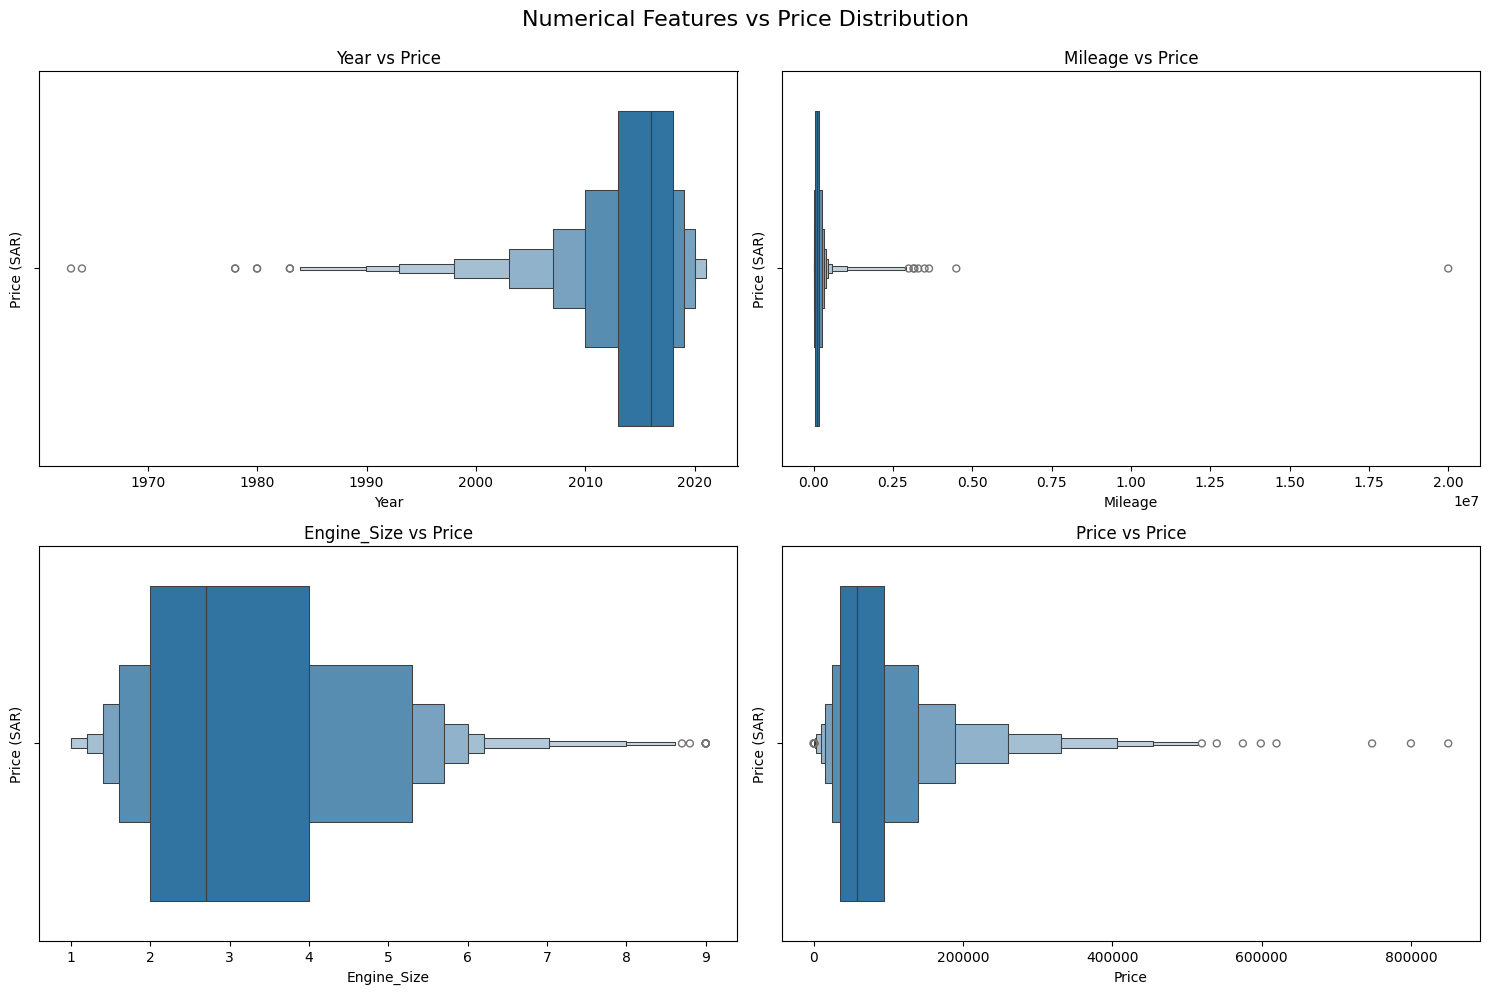

In [7]:
all_numerical_features = numerical_features + ['Price']

# create boxplot for numerical features
fig, axes = plt.subplots(2, 2, figsize=(15,  10))
fig.suptitle('Numerical Features vs Price Distribution', fontsize=16, y=0.99)

for idx, feature in enumerate(all_numerical_features):
    row = idx // 2
    col = idx % 2

    sns.boxenplot(data=df, x=feature, ax=axes[row, col])
    
    axes[row, col].set_title(f'{feature} vs Price')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()


### Remove outliers

There is strange outlier in `Mileage` (top-right boxplot), the values seems odd `20.000.000` if we compare to other high mileage cars.

Let's drop this row for now, as it's too high even compared to other high mileage cars.


In [8]:
def remove_outliers(df, columns, n_std=3):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[np.abs(df[col] - mean) <= (n_std * std)]
    
    return df

def remove_outliers_iqr(df, columns, k=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[
            (df_clean[col] >= Q1 - k * IQR) & 
            (df_clean[col] <= Q3 + k * IQR)
        ]
    return df_clean

df_clean = remove_outliers_iqr(df, numerical_features)

df_clean.describe(include='all')


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,3530,3530,3530,3530,3530,3530,3530.000000,3530.000000,3530.000000,3530,3530.000000
unique,309,27,55,2,4,3,NaN,NaN,NaN,1,NaN
top,Accent,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,145,1524,792,3219,2695,1344,NaN,NaN,NaN,3530,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2015.796601,3.105156,115736.320963,NaN,81212.944193
std,NaN,NaN,NaN,NaN,NaN,NaN,3.241046,1.382896,89529.201686,NaN,73078.417447
min,NaN,NaN,NaN,NaN,NaN,NaN,2006.000000,1.000000,100.000000,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,2.000000,48000.000000,NaN,38000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,99000.000000,NaN,60000.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,169225.000000,NaN,98000.000000


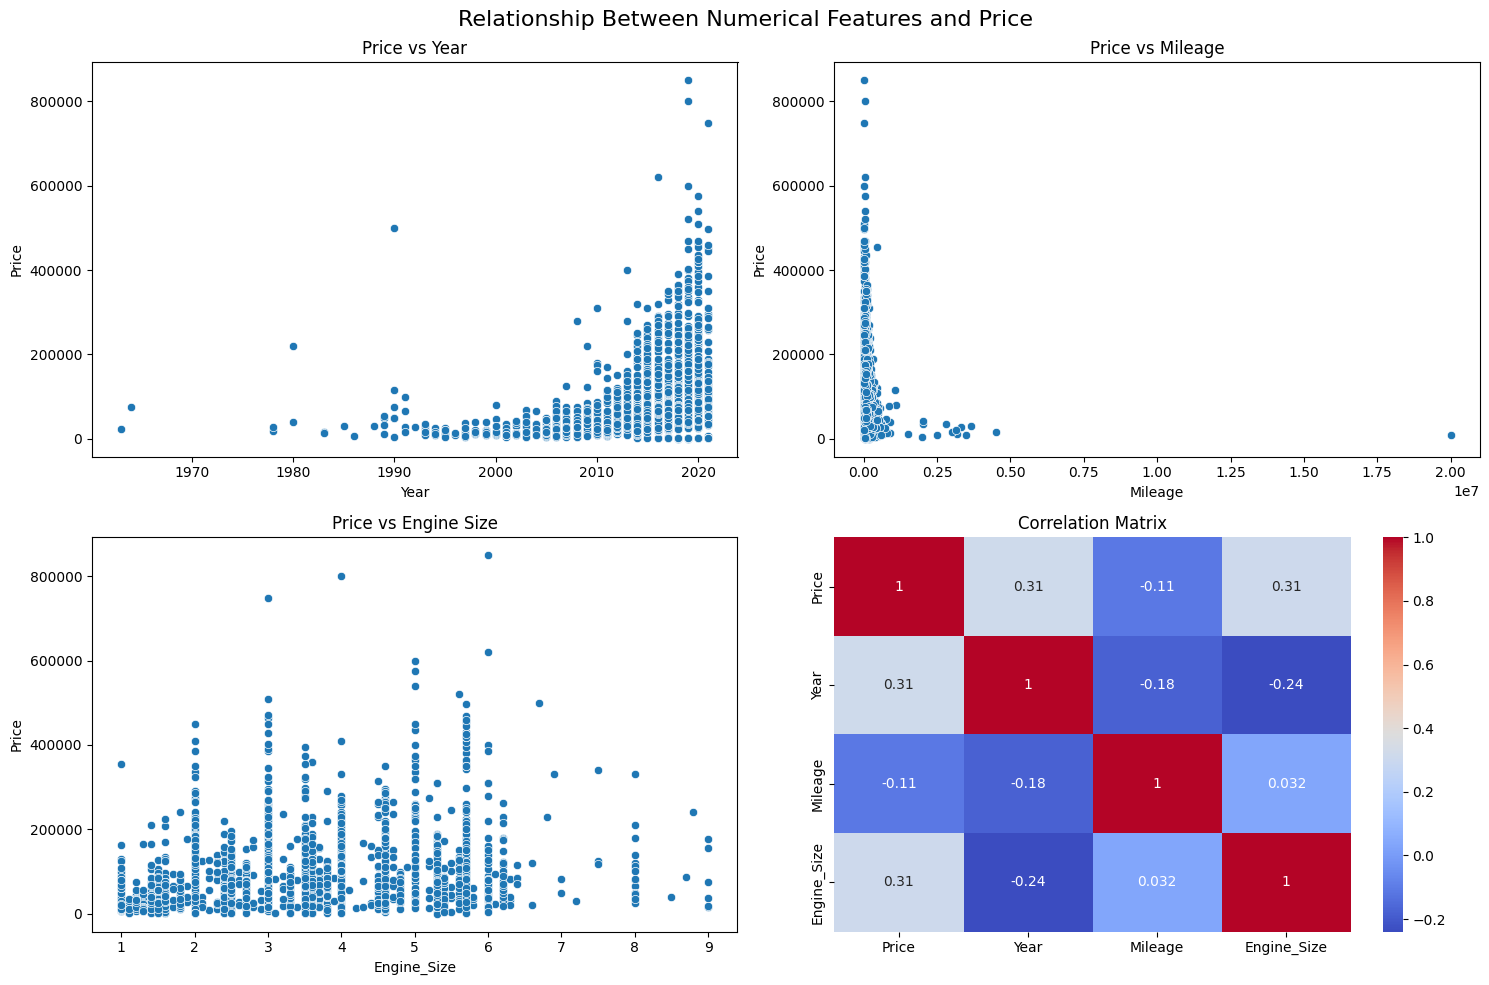


Correlation with Price:
Year: 0.314
Mileage: -0.113
Engine_Size: 0.308


In [9]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship Between Numerical Features and Price', fontsize=16)

# Plot Price vs Year
sns.scatterplot(data=df[df['Price'] > 0], x='Year', y='Price', ax=axes[0,0])
axes[0,0].set_title('Price vs Year')

# Plot Price vs Mileage
sns.scatterplot(data=df[df['Price'] > 0], x='Mileage', y='Price', ax=axes[0,1])
axes[0,1].set_title('Price vs Mileage')

# Plot Price vs Engine_Size
sns.scatterplot(data=df[df['Price'] > 0], x='Engine_Size', y='Price', ax=axes[1,0])
axes[1,0].set_title('Price vs Engine Size')

# Calculate correlation
correlation_matrix = df[['Price', 'Year', 'Mileage', 'Engine_Size']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation values with Price
print("\nCorrelation with Price:")
for col in ['Year', 'Mileage', 'Engine_Size']:
    correlation = df[col].corr(df['Price'])
    print(f"{col}: {correlation:.3f}")

### Result

1. `Year vs Price`
    - Moderately negative correlation (0.31)
    - Almost linear with significant outliers (old cars and high price luxury cars)

2. `Mileage vs Price`
    - Negative weak correlation (-0.19)
    - Non linear

3. `Engine_Size vs Price`
    - Positive correlation (0.35)
    - Non linear correlation

Since both linear and non-linear correlation is present, we'll keep all of them, and to *assess* which model is the most suitable, together with categorical features.


## Categorical Features Correlation

Let's see the distribution of the price by each categorical feature.

### Boxplot distribution of price by each categorical feature

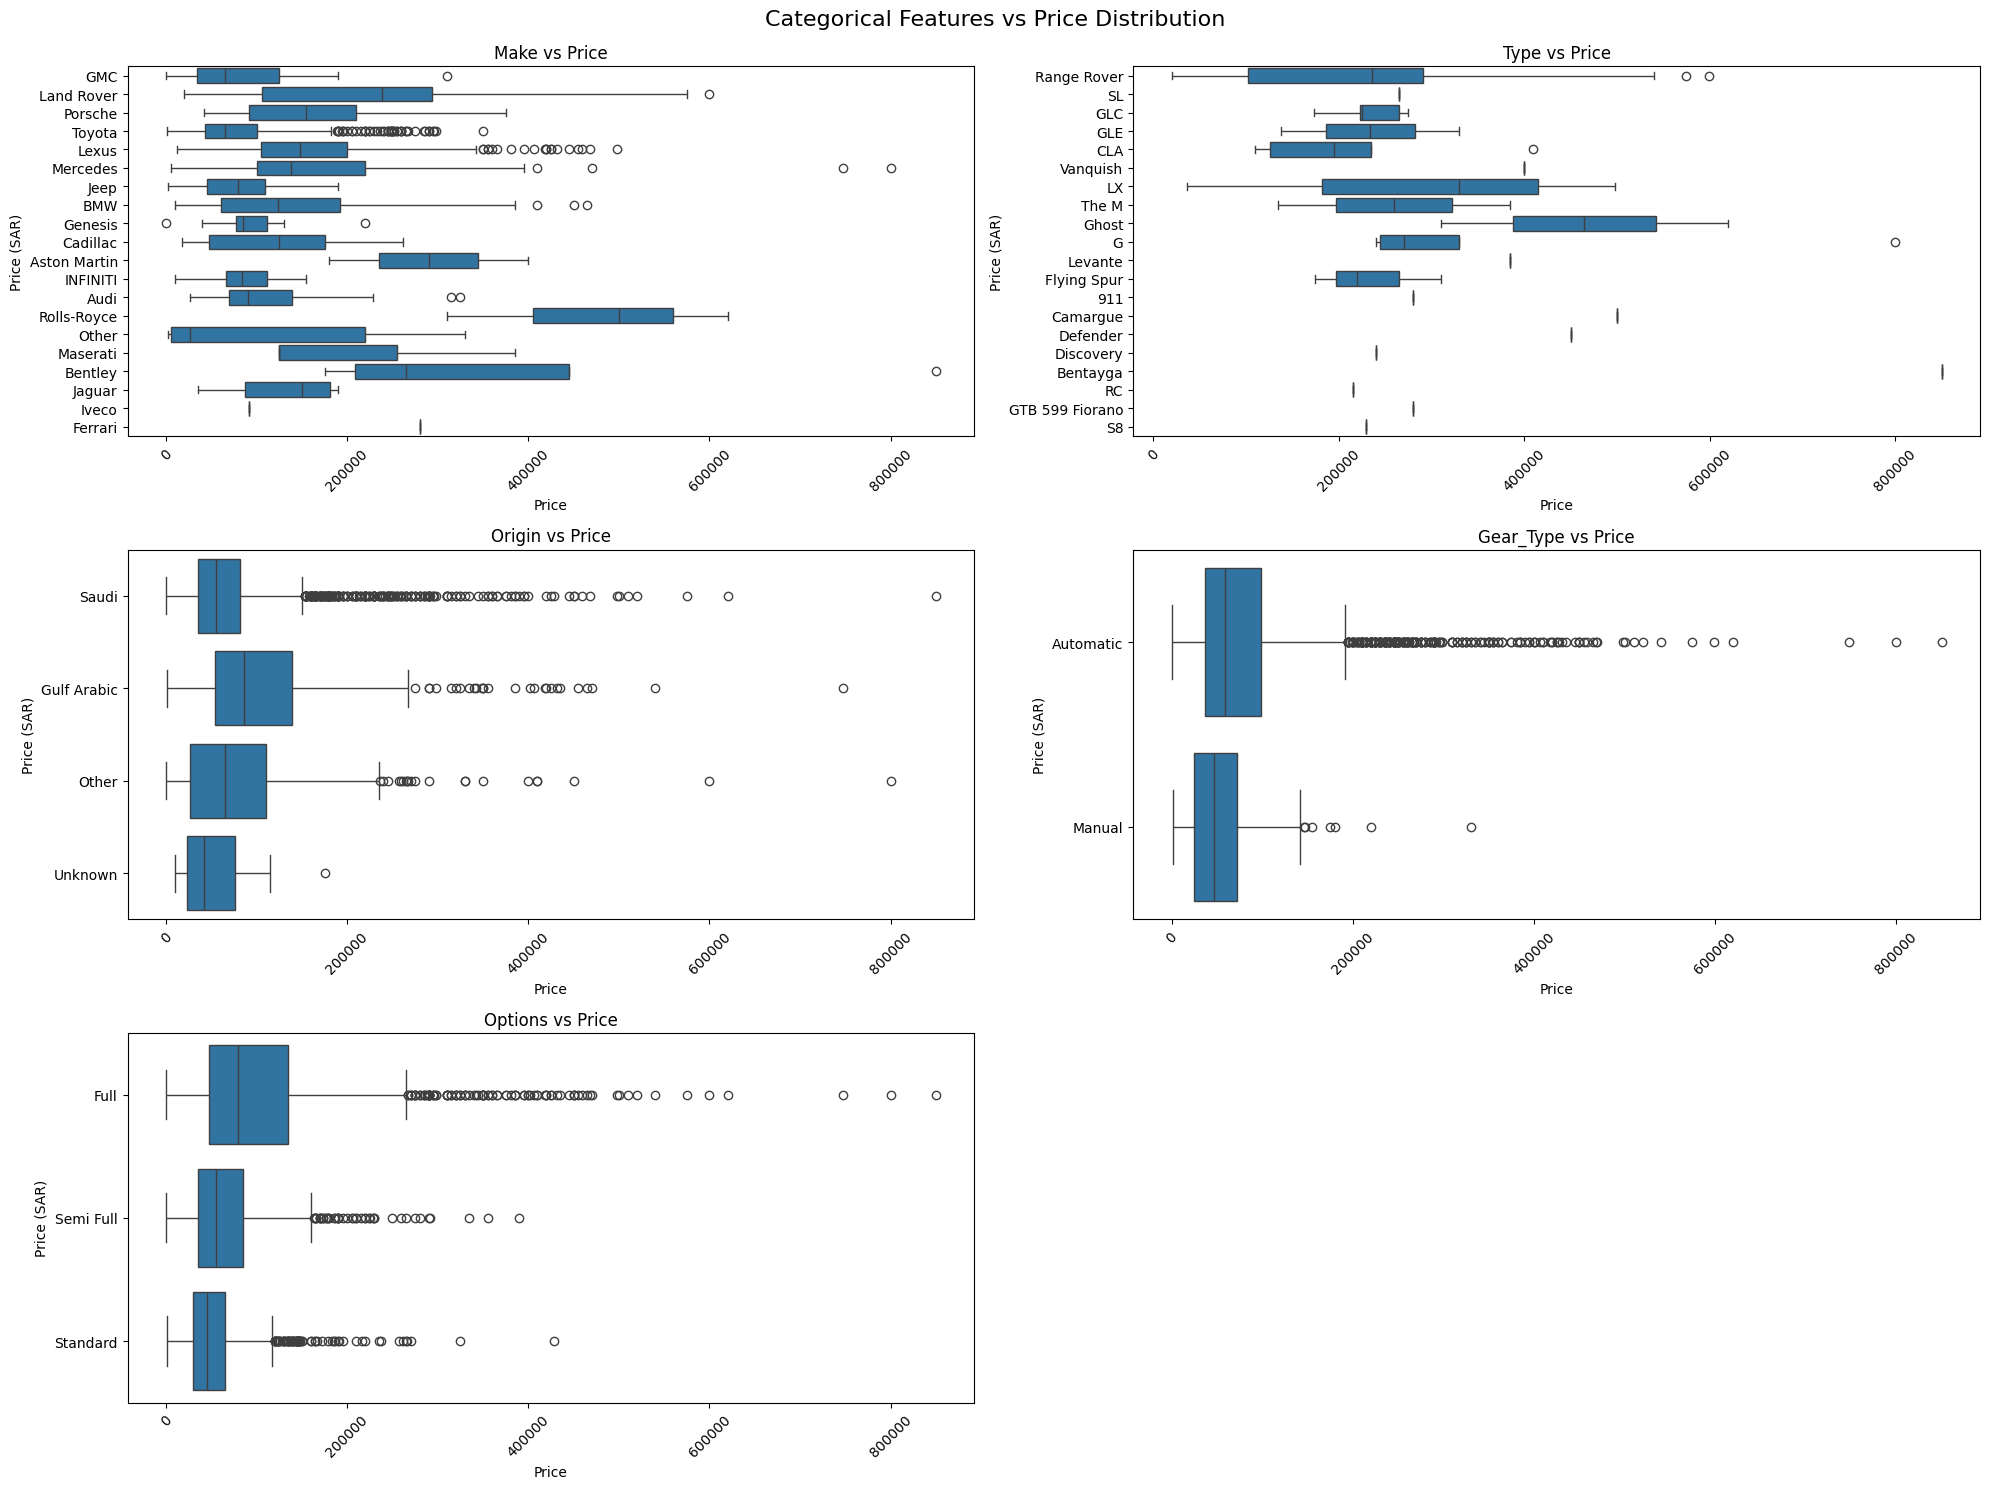

In [10]:
# Create boxplot for categorical features vs price
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Categorical Features vs Price Distribution', fontsize=16, y=0.99)

# Select top 4 categorical features based on their correlation
important_cats = ['Make', 'Type', 'Origin', 'Gear_Type', 'Options']

for idx, feature in enumerate(important_cats):
    row = idx // 2
    col = idx % 2
    
    if not (row == 2 and col == 1):
        # Calculate mean price for each category
        mean_prices = df.groupby(feature)['Price'].mean().sort_values(ascending=False).head(20)
        
        # Create bar plot
        sns.boxplot(data=df[df[feature].isin(mean_prices.index)], 
                    x='Price', y=feature,
                    ax=axes[row, col])
        
        axes[row, col].set_title(f'{feature} vs Price')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel('Price (SAR)')

axes[2, 1].set_visible(False)
plt.tight_layout()
plt.show()



## Data preprocessing

In [11]:
df_encoded = df.copy()

### Encoding

Based on observation, we have 3 types of categorical features:

1. Ordinal features: `Options` -> this is showing a car's interior features: `standard`, `semi-full` and `full`

2. Low cardinality features: `Gear_Type`, `Origin`

3. High cardinality features: `Type`, `Region`, `Make`



Some notes on the feature engineering:

1. Ordinal features is having order of options (`Standard` lower class, `Semi Full` middle class, `Full` higher class). So we will use `OrdinalEncoder` to encode this feature.

2. For high cardinality features, we will use `TargetEncoder` to encode the features.

3. For low cardinality features, we will use `OneHotEncoder`, because for our case, `Gear_Type` only has 2 unique values, and `Origin` only has 4 unique values.


## Model Development

We will test and evaluate 6 models to predict the price of the car:
- Linear Regression
- Ridge
- Lasso
- Random Forest
- XGBoost
- LightGBM

### Utility functions




In [12]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

"""
RMSLE is a more appropriate metric for this problem, since for price prediction,
under-predictions are more costly than over-predictions.

Negative values or zero values are clipped to a small positive value (1e-6) to avoid
logarithmic error.
"""
def rmsle(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 1e-6, None)
    y_true_clipped = np.clip(y_true, 1e-6, None)
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

"""
Global scoring metrics

Supporting: RMSE, MAE, R², RMSLE
RMSE is used for comparison purposes, while RMSLE is used for evaluation.
"""
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
    'rmsle': make_scorer(rmsle, greater_is_better=False)
}

"""
Print metrics for a given dataset

This is used for individual prediction evaluation.
"""
def print_metrics(y_true, y_pred, dataset_name=""):
    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    
    # Calculate percentage of predictions within different error margins
    for margin in [10, 20, 30]:
        within_margin = np.mean(np.abs((y_true - y_pred) / y_true) <= margin/100) * 100
        print(f"Within {margin}% margin: {within_margin:.2f}%")

"""
Plot learning curves
"""
def plot_learning_curves(model, X, y, metric='rmse'):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    eval_set = [(X_train, y_train), (X_val, y_val)]
    
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        eval_metric=metric,
        verbose=False
    )
    
    results = model.evals_result()
    
    plt.figure(figsize=(10, 6))
    plt.plot(results['validation_0']['rmse'], label='Train')
    plt.plot(results['validation_1']['rmse'], label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric.upper())
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

"""
Print the cross-validation results

cv_results: cross_validate results
scoring: scoring metrics to be shown
"""
def print_cv_results(cv_results, scoring_names):
    for metric in scoring_names:
        result_test = cv_results[f'test_{metric}']
        result_train = cv_results[f'train_{metric}']

        if result_test is not None:
            # For error metrics (rmse, mae, rmsle), negate the values
            if metric in ['rmse', 'mae', 'rmsle']:
                train_mean = -result_train.mean()
                train_std = result_train.std()
                test_mean = -result_test.mean()
                test_std = result_test.std()
            else:
                train_mean = result_train.mean()
                train_std = result_train.std()
                test_mean = result_test.mean()
                test_std = result_test.std()

            print(f"{metric.upper()}:")
            print(f"Train: {train_mean:.4f} (+/- {train_std * 2:.4f})")
            print(f"Test:  {test_mean:.4f} (+/- {test_std * 2:.4f})")
            print()

"""
Generate a preprocessing pipeline

It already set specific encoders for each feature type in our used cars dataset.
"""
def generate_model_pipeline():
    numeric_features = ['Mileage', 'Engine_Size']
    ordinal_feature = ['Options']
    binary_features = ['Gear_Type']
    low_card_features = ['Origin']
    high_card_features = ['Make', 'Type', 'Region']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    year_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder(categories=[options]))
    ])

    binary_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])

    low_card_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse_output=False))
    ])

    high_card_transformer = Pipeline(steps=[
        ('target', TargetEncoder())
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('year', year_transformer, ['Year']),
            ('num', numeric_transformer, numeric_features),
            ('ord', ordinal_transformer, ordinal_feature),
            ('binary', binary_transformer, binary_features),
            ('low_card', low_card_transformer, low_card_features),
            ('high_card', high_card_transformer, high_card_features)
        ],
        remainder='drop'
    )

    return preprocessor

## Enchanced Feature Engineering

So, apparently there are many data that are not making sense, like price = 1 SAR, or 500 SAR. Moreover, we also have non-linear correlation for high price cars (> 200,000 SAR).

Let's try to remove the outliers by using a more enhanced method. We'll use IQR to remove the outliers, and we'll also add some additional checks for unrealistic price/mileage ratios, and unrealistic mileage per year.



Outliers removed:
Price: 327 rows (8.55%)
Mileage: 112 rows (2.93%)
Year: 138 rows (3.61%)
Engine_Size: 27 rows (0.71%)
Removed rows are:


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
17,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,2019,4.6,71000,False,200000
28,Pathfinder,Al-Ahsa,Nissan,Automatic,Saudi,Semi Full,2002,3.3,550000,False,10000
46,Elantra,Abha,Hyundai,Automatic,Saudi,Semi Full,2020,2.0,27000,False,1010
...,...,...,...,...,...,...,...,...,...,...,...
5595,Land Cruiser,Dammam,Toyota,Manual,Saudi,Standard,2007,4.5,480000,False,65000
5598,Yukon,Dammam,GMC,Automatic,Saudi,Full,2009,5.3,440000,False,45000
5599,Corolla,Dammam,Toyota,Manual,Other,Standard,1997,1.3,32500,False,7000
5601,Macan,Jeddah,Porsche,Automatic,Saudi,Semi Full,2018,2.0,36000,False,210000


"total removed: {'Price': 327, 'Mileage': 112, 'Year': 138, 'Engine_Size': 27}"


Potential data quality issues found:
- Found 33 suspicious price/mileage ratios


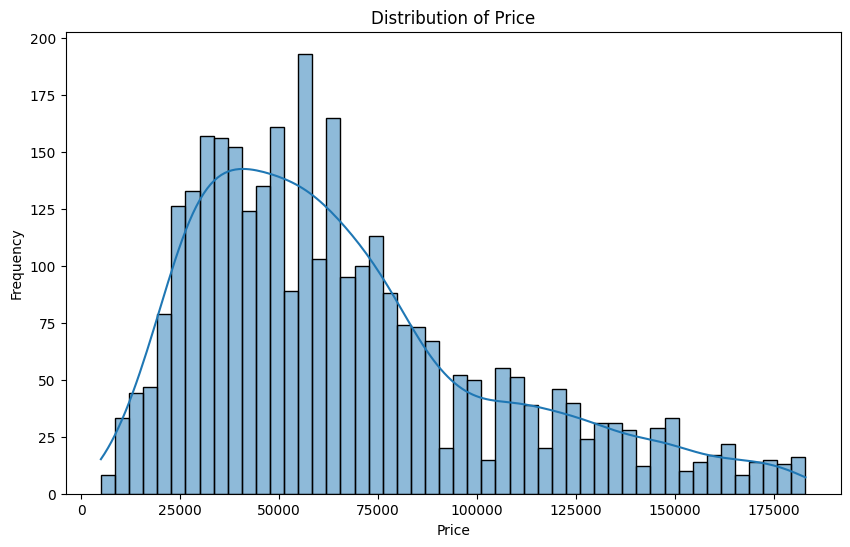

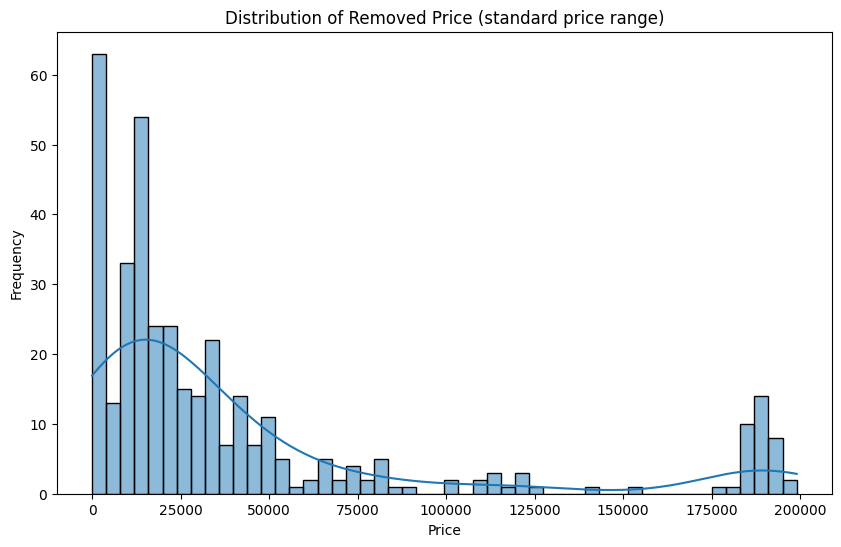

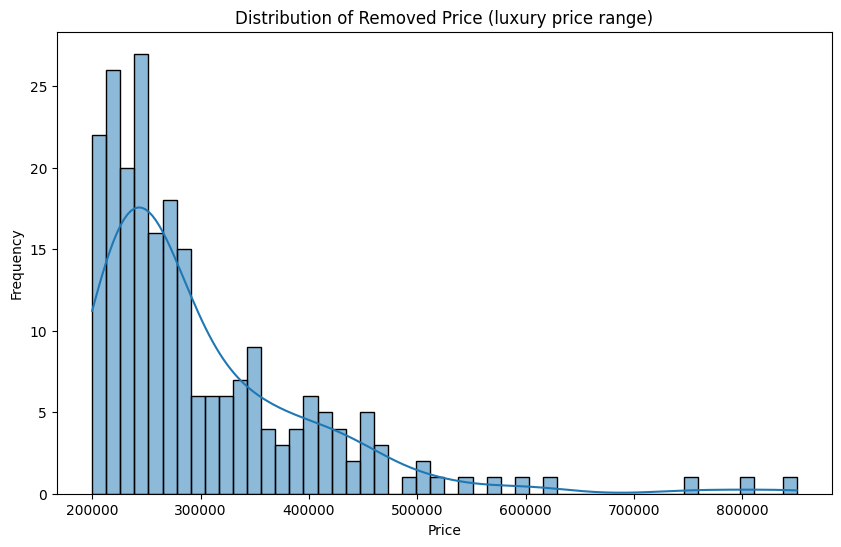

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Age,MileagePerYear,PricePerAge,PricePerMile,MakePriceMean,MakePriceStd,PriceSegment
count,3220,3220,3220,3220,3220,3220,3220.000000,3220.000000,3220.000000,3220,3220.00000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220
unique,294,27,53,2,4,3,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,Accent,Riyadh,Toyota,Automatic,Saudi,Standard,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard
freq,144,1394,735,2913,2497,1208,NaN,NaN,NaN,3220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,831
mean,NaN,NaN,NaN,NaN,NaN,NaN,2015.548447,3.034006,122645.218634,NaN,66766.65000,8.451553,14230.867944,9784.765958,22.123747,66766.650000,31533.150453,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,3.231343,1.355942,91499.094857,NaN,38409.23946,3.231343,8852.510525,8080.301473,99.404439,20035.008646,9598.645482,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,2006.000000,1.000000,100.000000,NaN,5000.00000,3.000000,6.529412,277.777778,0.013158,15000.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,2.000000,55000.000000,NaN,38000.00000,6.000000,8178.030303,4375.000000,0.272649,49736.238532,22386.404846,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,105960.000000,NaN,58000.00000,8.000000,14000.000000,7650.000000,0.603193,68009.328358,32463.931330,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,3.800000,179000.000000,NaN,85000.00000,10.000000,19629.250000,12500.000000,1.491874,74501.632653,36067.352565,NaN


In [13]:
def remove_outliers_enhanced(df, columns, k=1.5):
    """
    Enhanced outlier removal with multiple strategies and logging.
    Returns both clean dataframe and outlier rows.
    
    Args:
        df: Input dataframe
        columns: List of columns to check for outliers
        k: IQR multiplier for outlier detection
        
    Returns:
        tuple: (clean_df, outlier_df, removed_counts)
    """
    df_clean = df.copy()
    removed_counts = {}
    initial_count = len(df_clean)
    outlier_mask = pd.Series(False, index=df.index)
    
    for col in columns:
        # Calculate IQR bounds
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        # Additional checks for specific columns
        if col == 'Price':
            lower_bound = max(lower_bound, 5000)  # Minimum realistic price
            upper_bound = min(upper_bound, 400000)  # Maximum realistic price
            
        elif col == 'Mileage':
            upper_bound = min(upper_bound, 500000)  # Max realistic mileage
            
        elif col == 'Year':
            lower_bound = max(lower_bound, 1990)  # Oldest realistic year
            upper_bound = min(upper_bound, 2024)  # Newest possible year
            
        # Identify outliers for this column
        col_outliers = ~((df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound))
        outlier_mask = outlier_mask | col_outliers
        
        # Update clean dataframe
        df_clean = df_clean[~col_outliers]
        
        removed_counts[col] = initial_count - len(df_clean)
        initial_count = len(df_clean)
    
    # Get outlier rows
    outlier_df = df[outlier_mask]
    
    print("\nOutliers removed:")
    for col, count in removed_counts.items():
        print(f"{col}: {count} rows ({(count/len(df))*100:.2f}%)")
        
    return df_clean, outlier_df, removed_counts

def engineer_features(df):
    df = df.copy()
    
    # Add more robust features
    current_year = 2024
    df['Age'] = current_year - df['Year']
    df['MileagePerYear'] = df['Mileage'] / df['Age']
    
    # Add price density features to help with unusual cases
    df['PricePerAge'] = df['Price'] / df['Age']
    df['PricePerMile'] = df['Price'] / df['Mileage']
    
    # Create make-specific statistics
    make_stats = df.groupby('Make')['Price'].agg(['mean', 'std']).fillna(0)
    df['MakePriceMean'] = df['Make'].map(make_stats['mean'])
    df['MakePriceStd'] = df['Make'].map(make_stats['std'])
    
    # Price segments for stratification
    df['PriceSegment'] = pd.qcut(df['Price'], q=4, labels=['Standard', 'MidRange', 'Premium', 'Luxury'])
    
    return df

def validate_data_quality(df):
    """
    Validate data quality and identify potential issues
    """
    issues = []
    
    # Check for unrealistic price/mileage ratios
    price_per_mile = df['Price'] / df['Mileage']
    suspicious_ratio = price_per_mile > price_per_mile.quantile(0.99)
    if suspicious_ratio.any():
        issues.append(f"Found {suspicious_ratio.sum()} suspicious price/mileage ratios")
    
    # Check for unrealistic mileage per year
    mileage_per_year = df['Mileage'] / (2024 - df['Year'])
    suspicious_mileage = mileage_per_year > 100000  # More than 100k km per year
    if suspicious_mileage.any():
        issues.append(f"Found {suspicious_mileage.sum()} unrealistic yearly mileage")
    
    return issues

df_cleaned, df_removed, total_removed = remove_outliers_enhanced(raw_df, ['Price', 'Mileage', 'Year', 'Engine_Size'])

print("Removed rows are:")
display(df_removed)
display(f"total removed: {total_removed}")

# Add engineered features
df_engineered = engineer_features(df_cleaned)
df_removed_engineered = engineer_features(df_removed)

# Validate data quality
issues = validate_data_quality(df_engineered)
if issues:
    print("\nPotential data quality issues found:")
    for issue in issues:
        print(f"- {issue}")

# Proceed with model training using cleaned and engineered data
X = df_engineered.drop(['Price', 'PriceSegment'], axis=1)
y = df_engineered['Price']

# plot the distribution of df_engineered['Price']
plt.figure(figsize=(10, 6))
sns.histplot(df_engineered['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# plot df_removed
plt.figure(figsize=(10, 6))
sns.histplot(df_removed[df_removed['Price'] < 200000]['Price'], bins=50, kde=True)
plt.title('Distribution of Removed Price (standard price range)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_removed[df_removed['Price'] >= 200000]['Price'], bins=50, kde=True)
plt.title('Distribution of Removed Price (luxury price range)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

df_engineered.describe(include='all')

## Model Development and Evaluation

We skip scaling the independent variables / features because it's already scaled in the preprocessing step.

However, we don't scale the *target variable* / `Price`, since it's important for encoding categorical features. Also some of our picked models (XGBoost, LightGBM) are more suitable for non-scaled target variables.


Let's try to improve the model by using pipeline and cross validation, to have consistent and better model performance and evaluation.

In [14]:
import warnings
warnings.filterwarnings('ignore')

# Create price bins for stratification
def create_price_bins(y, n_bins=5):
    # return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
    return pd.qcut(np.log1p(y), q=n_bins, labels=False, duplicates='drop')

# First remove outliers
# raw_df is the original dataframe with removed duplicates and price = 0 rows
# df_clean = remove_outliers_iqr(raw_df, numerical_features)

# X_clean = df_clean.drop('Price', axis=1)
# y_clean = df_clean['Price']

X_clean = df_engineered.drop(['Price', 'PriceSegment'], axis=1)
y_clean = df_engineered['Price']

# show the distribution of 2 price group
display(df_engineered['PriceSegment'].value_counts())

PriceSegment
Standard    831
MidRange    806
Premium     803
Luxury      780
Name: count, dtype: int64

In [15]:
import warnings
warnings.filterwarnings('ignore')


X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y_clean, 
    test_size=0.2,
    random_state=42
)

xgb_params = {
    'n_estimators': 1378,  # from iterative manual tuning
    'max_depth': 7,               
    'min_child_weight': 6,         
    'reg_alpha': 1.5,              
    'reg_lambda': 6.0,
    'random_state': 42
}

preprocessor = generate_model_pipeline()

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**xgb_params))
])

# Simple cross-validation with standard metrics
cv = KFold(n_splits=20, shuffle=True, random_state=42)
cv_results = cross_validate(
    model_pipeline,
    X_clean,
    y_clean,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Print results
print_cv_results(cv_results, scoring.keys())


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_se

RMSE:
Train: 9762.8995 (+/- 414.8078)
Test:  14350.8285 (+/- 3115.3444)

MAE:
Train: 6415.5571 (+/- 265.5738)
Test:  9701.4573 (+/- 1580.8804)

R2:
Train: 0.9353 (+/- 0.0056)
Test:  0.8573 (+/- 0.0538)

RMSLE:
Train: 0.1728 (+/- 0.0504)
Test:  0.2383 (+/- 0.0533)



## Result


### Cross-validation results (using manually found optimum parameters):

```
RMSE:
Train: 9762.8995 (+/- 414.8078)
Test:  14350.8285 (+/- 3115.3444)

MAE:
Train: 6415.5571 (+/- 265.5738)
Test:  9701.4573 (+/- 1580.8804)

R2:
Train: 0.9353 (+/- 0.0056)
Test:  0.8573 (+/- 0.0538)

RMSLE:
Train: 0.1728 (+/- 0.0504)
Test:  0.2383 (+/- 0.0533)
```

From the results, we can see the model performance is quite good after enhancing the outliers removal, since RMSLE is `0.2383` (0 is perfect). Additionally, the training and test scores for RMSLE are similar, which means the model is relatively low overfitting.

R2 score is also good, since it's close to 1 (both > `0.85`). The overfitting is shown by higher score of training metrics compared to test metrics, although the difference is not too high.

The usage of RMSLE is more appropriate for this problem, since under-predictions are more costly than over-predictions, i.e. the cost of overestimating a car price is not as bad as the cost of underestimating it.

Some notes:

- The model will perform best on mid range car prices, i.e. 20,000 - 180,000 SAR.

- Due to our outliers removal, the model will be expected to perform worse on budget and, probably worst on luxury cars, 200,000 SAR and above, because price variance is too high.



## Improving accuracy with Ensemble method

As mentioned before, the model performance is great, but not perfect. Let's try to see if ensemble method can improve the accuracy of our model.

We'll use Stacking method, with Random Forest, XGBoost and LightGBM as base models. The reason is that these models are tree-based models, which are less prone to outliers in high variance price data.


In [18]:
from sklearn.model_selection import StratifiedKFold

# First level (base) models
base_models = [
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    )),
    ('lgbm', LGBMRegressor(
        n_estimators=200,
        num_leaves=25,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ('lasso', Lasso(alpha=0.01))
]

meta_model =  XGBRegressor(**xgb_params)

# Create stacking ensemble
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Create the full pipeline with preprocessing and stacking
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stacking)
])

# Modified cross-validation
price_bins = create_price_bins(y_clean)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Train and evaluate the stacking model
print("Training stacking ensemble...")

cv_scores = cross_validate(
    stacking_pipeline,
    X_clean,
    y_clean,
    cv=cv.split(X_clean, price_bins),
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print("\nCross-validation results:")
print_cv_results(cv_scores, scoring.keys())

Training stacking ensemble...


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_se

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16385
[LightGBM] [Info] Number of data points in the train set: 2576, number of used features: 832
[LightGBM] [Info] Start training from score 66860.782609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16542
[LightGBM] [Info] Number of data points in the train set: 2576, number of used features: 842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e+11, tolerance: 3.782e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e+11, tolerance: 3.779e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15933
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 819
[LightGBM] [Info] Start training from score 67216.158738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15849
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 828
[LightGBM] [Info] Start training from score 67588.624757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e+11, tolerance: 3.058e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16004
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 837
[LightGBM] [Info] Start training from score 67605.341748


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+11, tolerance: 3.107e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+11, tolerance: 3.121e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15835
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 820
[LightGBM] [Info] Start training from score 66638.814168


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+11, tolerance: 2.997e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+11, tolerance: 2.998e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15871
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 827
[LightGBM] [Info] Start training from score 66447.939350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15836
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 829
[LightGBM] [Info] Start training from score 66788.173702


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+11, tolerance: 3.045e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+11, tolerance: 2.993e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16006
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 827
[LightGBM] [Info] Start training from score 66651.680252


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e+11, tolerance: 3.013e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+11, tolerance: 2.979e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15840
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 838
[LightGBM] [Info] Start training from score 66757.066473


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e+11, tolerance: 3.040e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+11, tolerance: 3.074e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15909
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 820
[LightGBM] [Info] Start training from score 66344.739932


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+11, tolerance: 3.078e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15910
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 830
[LightGBM] [Info] Start training from score 66487.373120


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e+11, tolerance: 3.038e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15914
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 826
[LightGBM] [Info] Start training from score 66463.933042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16284
[LightGBM] [Info] Number of data points in the train set: 2061, number of used features: 826
[LightGBM] [Info] Start training from score 66358.236778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16043
[LightGBM] [Info] Number of data points in th

## Ensemble Result

```
RMSE:
Train: 10149.9024 (+/- 391.6830)
Test:  14385.5125 (+/- 957.1026)

MAE:
Train: 6628.0353 (+/- 293.1553)
Test:  9597.8892 (+/- 749.6925)

R2:
Train: 0.9301 (+/- 0.0056)
Test:  0.8597 (+/- 0.0118)

RMSLE:
Train: 0.1620 (+/- 0.0079)
Test:  0.2363 (+/- 0.0111)
```

Comparing the ensemble model against the XGBoost-only model:

| Metric | XGBoost Only | Ensembled Model | Improvement |
|--------|--------------|-----------------|-------------|
| Train RMSE | 9762.90 ± 414.81 | 10149.90 ± 391.68 | 🔄 Similar |
| Test RMSE | 14350.83 ± 3115.34 | 14385.51 ± 957.10 | ✅ Similar accuracy, much better variance |
| Train MAE | 6415.56 ± 265.57 | 6628.04 ± 293.16 | 🔄 Similar |
| Test MAE | 9701.46 ± 1580.88 | 9597.89 ± 749.69 | ✅ Better accuracy and variance |
| Train R² | 0.9353 ± 0.0056 | 0.9301 ± 0.0056 | 🔄 Similar |
| Test R² | 0.8573 ± 0.0538 | 0.8597 ± 0.0118 | ✅ Similar accuracy, much better variance |
| Train RMSLE | 0.1728 ± 0.0504 | 0.1620 ± 0.0079 | ✅ Better accuracy and variance |
| Test RMSLE | 0.2383 ± 0.0533 | 0.2363 ± 0.0111 | ✅ Better accuracy and variance |

### Key Improvements
1. **More Stable Predictions**: The ensemble model shows significantly lower variance across all metrics, particularly in test scores
2. **Better RMSLE**: Both training and test RMSLE improved, with much better stability
3. **Consistent MAE**: Test MAE improved slightly while maintaining better variance
4. **Robust R² Score**: Similar R² scores but with much more stable test performance

### Benefits
- More reliable predictions across different price ranges
- Lower risk of extreme prediction errors (reduced variance)
- Better for business decision-making due to consistency
- Improved generalization across different types of cars


## Conclusion

We can conclude that by combining robust outlier removal and feature engineering, we can achieve a good model performance, with RMSLE `0.2363` (0 is perfect).

Ensembling model apparently improves the accuracy slightly only. However, the error variance is greatly reduced, making ensemble model more reliable.

For our car prediction model, this improved stability is more important, since the car price prediction is a business decision-making process, and it's better to have a consistent model performance.

Thus, our final model is the ensemble model, with RMSLE `0.2363` (0 is perfect).

## Limitations

The final model is still not perfect, due to several factors:

1. Slight overfitting in the training data (higher training R² compared to test R²).

2. Since preprocessing has removed low-price and luxury cars, the model may not perform well on those cars.

## Recommendations

1. We will need to create specific models for low-price and luxury cars, since the model is not performing well on those cars.

2. We can try to use more advanced models, such as using Neural Networks for the clean dataset as well as low-price and luxury cars.

3. We can find more Saudi dataset to train the model (in case we are going to use Neural Network, because NN potentials will grow better with more data).


## Export the model

We will export to Pickle file, so it can be used in other Python projects / deploy to cloud to do online prediction.

In [55]:
import pickle
import os

# Train the final model on the full dataset
print("Training final model on full dataset...")
df_cleaned, df_removed, total_removed = remove_outliers_enhanced(raw_df, ['Price', 'Mileage'])

X_all, y_all = df_cleaned.drop(['Price'], axis=1), df_cleaned['Price']
stacking_pipeline.fit(X_all, y_all)

# Save the model
model_path = 'models/saudi_cars_price_predictor.pkl'

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model
with open(model_path, 'wb') as f:
    pickle.dump(stacking_pipeline, f)

print(f"\nModel saved to {model_path}")

# Optional: Test loading and prediction
print("\nTesting model loading and prediction...")
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Test prediction on a few samples
test_samples = X_all.head(10)
predictions = loaded_model.predict(test_samples)
actual = y_all.head(10)

print("\nSample Predictions vs Actual:")
for pred, act in zip(predictions, actual):
    print(f"Predicted: {pred:,.2f} SAR, Actual: {act:,.2f} SAR")

Training final model on full dataset...

Outliers removed:
Price: 327 rows (8.55%)
Mileage: 112 rows (2.93%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19417
[LightGBM] [Info] Number of data points in the train set: 3385, number of used features: 873
[LightGBM] [Info] Start training from score 65187.773412


/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e+11, tolerance: 5.102e+08
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19074
[LightGBM] [Info] Number of data points in the train set: 2708, number of used features: 872
[LightGBM] [Info] Start training from score 65917.025111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19051
[LightGBM] [Info] Number of data points in the train set: 2708, number of used features: 872
[LightGBM] [Info] Start training from score 65188.668021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+11, tolerance: 4.141e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.612e+11, tolerance: 4.016e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


Model saved to models/saudi_cars_price_predictor.pkl

Testing model loading and prediction...

Sample Predictions vs Actual:
Predicted: 122,809.84 SAR, Actual: 120,000.00 SAR
Predicted: 39,352.59 SAR, Actual: 42,000.00 SAR
Predicted: 64,568.51 SAR, Actual: 58,000.00 SAR
Predicted: 110,775.30 SAR, Actual: 85,000.00 SAR
Predicted: 42,649.32 SAR, Actual: 48,000.00 SAR
Predicted: 74,673.53 SAR, Actual: 81,500.00 SAR
Predicted: 41,626.88 SAR, Actual: 55,000.00 SAR
Predicted: 111,562.52 SAR, Actual: 145,000.00 SAR
Predicted: 45,296.22 SAR, Actual: 38,000.00 SAR
Predicted: 142,560.48 SAR, Actual: 140,000.00 SAR
